<a href="https://www.kaggle.com/code/ishanmitra96/nlp-fake-news-cnn-lstm-and-transformers?scriptVersionId=175327533" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-detection/true.csv
/kaggle/input/fake-news-detection/fake.csv


# Loading the dataset

In [2]:
true_df = pd.read_csv("/kaggle/input/fake-news-detection/true.csv")
true_df

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [3]:
fake_df = pd.read_csv("/kaggle/input/fake-news-detection/fake.csv")
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


# Data Preprocessing

https://github.com/remydeshayes/NLP_Pytorch/blob/main/Notebook%20-%20Fake_News%20Detection%20Pytorch%20-%20Billiot_Deshayes.ipynb

Preprocessing of true and fake datasets for data optimisation and removal of blank and duplicate entries.

## Verified News Dataset

In [4]:
# TRUE DATASET
# Checking for NaN values
true_df.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [5]:
true_df['text']

0        WASHINGTON (Reuters) - The head of a conservat...
1        WASHINGTON (Reuters) - Transgender people will...
2        WASHINGTON (Reuters) - The special counsel inv...
3        WASHINGTON (Reuters) - Trump campaign adviser ...
4        SEATTLE/WASHINGTON (Reuters) - President Donal...
                               ...                        
21412    BRUSSELS (Reuters) - NATO allies on Tuesday we...
21413    LONDON (Reuters) - LexisNexis, a provider of l...
21414    MINSK (Reuters) - In the shadow of disused Sov...
21415    MOSCOW (Reuters) - Vatican Secretary of State ...
21416    JAKARTA (Reuters) - Indonesia will buy 11 Sukh...
Name: text, Length: 21417, dtype: object

In [6]:
# Download stopwords from nltk library
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Define function for most common words
# https://github.com/remydeshayes/NLP_Pytorch/blob/main/Notebook%20-%20Fake_News%20Detection%20Pytorch%20-%20Billiot_Deshayes.ipynb
from collections import Counter


def most_common(corpus, nb_words):
    articles = corpus.str.split()
    # Explanation of nested list comprehension:
    # Iterate through every article in articles
    # Iterate through every word in article (second for in loop)
    # Add word to the np.array if it is not a stopword (nltk)
    words = np.array([word for article in articles for word in article if word.lower() not in stopwords])
    counter = Counter(words)
    d = pd.DataFrame(counter, index=['occurences']).transpose().reset_index()
    d.columns = ['word', 'occurences']
    d = d.sort_values('occurences', ascending=False)
    return d[:nb_words]

In [8]:
# This is VERY HIGH cpu compute (but it only takes a few seconds)
most_common(true_df['text'], 10)

,word,occurences
113,said,72025
7,U.S.,38271
73,Trump,36461
162,would,31330
2,-,31059
136,said.,21582
1,(Reuters),21239
71,President,17112
79,also,15703
164,United,15030


Even without computing the occurences, we notice the presence of the format "CITY (Reuters) - " at the beginning of each article. This is missing in all the articles from the fake_df.
We will delete this pattern format where it is present in the article within the first 50 characters of an article.
Failing to clean this would create a bias where perhaps, presence of the word Reuters would equate to non-falsified news.

In [9]:
import re

In [10]:
for i in range(0, len(true_df['text'])):
    try :
        # Search if CITY (Reuters) exist, if it does, shift the index
        # to 3 more spaces to accomodate the hyphen
        start = re.search('(Reuters)',true_df['text'][i][0:49]).end() + 3
    except:
        pass
    else:
        true_df['text'][i] = true_df['text'][i][start:]

In [11]:
true_df

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,NATO allies on Tuesday welcomed President Don...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LexisNexis, a provider of legal, regulatory a...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,In the shadow of disused Soviet-era factories...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,Vatican Secretary of State Cardinal Pietro Pa...,worldnews,"August 22, 2017"


In [12]:
# Check for duplicates or blank articles
# Conversion to dataframe to reduce output text clutter
duplicate = true_df['text'].value_counts()[true_df['text'].value_counts()>1]
duplicate = duplicate.rename_axis('unique_values').reset_index(name='counts')
duplicate

,unique_values,counts
0,Highlights for U.S. President Donald Trump’s ...,8
1,Highlights for U.S. President Donald Trump’s ...,5
2,Highlights of the day for U.S. President Dona...,5
3,Highlights for U.S. President Donald Trump’s ...,3
4,German Chancellor Angela Merkel s conservativ...,2
...,...,...
207,U.S. President Donald Trump ramped up his fig...,2
208,British Foreign Secretary Boris Johnson issue...,2
209,U.S. President Donald Trump struck a blow aga...,2
210,Facebook Inc (FB.O) Chief Operating Officer S...,2


In [13]:
# Number of duplicate entries
true_df['text'].value_counts()[true_df['text'].value_counts()>1].sum() - 212

225

In [14]:
# Deletion of duplicates
true_df = true_df.drop_duplicates(subset=['text'], ignore_index=True)

In [15]:
true_df.shape

(21192, 4)

In [16]:
# Concatenate title and text column
true_df['article'] = true_df['title'] + '.' + true_df['text']

/tmp/ipykernel_35/1747463966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_df['article'] = true_df['title'] + '.' + true_df['text']


In [17]:
true_df = true_df.drop(['title', 'text'], axis=1)

In [18]:
true_df

,subject,date,article
0,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t..."
1,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...
2,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...
3,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...
4,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...
...,...,...,...
21187,worldnews,"August 22, 2017",'Fully committed' NATO backs new U.S. approach...
21188,worldnews,"August 22, 2017",LexisNexis withdrew two products from Chinese ...
21189,worldnews,"August 22, 2017",Minsk cultural hub becomes haven from authorit...
21190,worldnews,"August 22, 2017",Vatican upbeat on possibility of Pope Francis ...


For future EDA analysis, we keep the date column for plotting metrics. Date is processed into a uniform format.

In [19]:
true_df['date_len'] = [len(x) for x in true_df['date']]
print(true_df['date_len'].value_counts())
true_df = true_df.drop(['date_len'], axis=1)

date_len
17    6262
18    5703
19    2495
14    2010
16    1699
15    1616
13    1183
12     224
Name: count, dtype: int64


In [20]:
true_df

,subject,date,article
0,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t..."
1,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...
2,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...
3,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...
4,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...
...,...,...,...
21187,worldnews,"August 22, 2017",'Fully committed' NATO backs new U.S. approach...
21188,worldnews,"August 22, 2017",LexisNexis withdrew two products from Chinese ...
21189,worldnews,"August 22, 2017",Minsk cultural hub becomes haven from authorit...
21190,worldnews,"August 22, 2017",Vatican upbeat on possibility of Pope Francis ...


In [21]:
from datetime import datetime

In [22]:
# All data format is uniform (month date, year)
# Unifying the date format to datetime
dates = []
for x in true_df['date']:
    date = datetime.strptime(x,'%B %d, %Y ')
    dates.append(date)
true_df['date'] = dates

In [23]:
true_df

,subject,date,article
0,politicsNews,2017-12-31,"As U.S. budget fight looms, Republicans flip t..."
1,politicsNews,2017-12-29,U.S. military to accept transgender recruits o...
2,politicsNews,2017-12-31,Senior U.S. Republican senator: 'Let Mr. Muell...
3,politicsNews,2017-12-30,FBI Russia probe helped by Australian diplomat...
4,politicsNews,2017-12-29,Trump wants Postal Service to charge 'much mor...
...,...,...,...
21187,worldnews,2017-08-22,'Fully committed' NATO backs new U.S. approach...
21188,worldnews,2017-08-22,LexisNexis withdrew two products from Chinese ...
21189,worldnews,2017-08-22,Minsk cultural hub becomes haven from authorit...
21190,worldnews,2017-08-22,Vatican upbeat on possibility of Pope Francis ...


In [24]:
true_df['date_len'] = [len(str(x)) for x in true_df['date']]
print(true_df['date_len'].value_counts())
true_df = true_df.drop(['date_len'], axis=1)

date_len
19    21192
Name: count, dtype: int64


Finally creating a label variable - 1 means the news is verified

In [25]:
true_df['label'] = 1

In [26]:
true_df

,subject,date,article,label
0,politicsNews,2017-12-31,"As U.S. budget fight looms, Republicans flip t...",1
1,politicsNews,2017-12-29,U.S. military to accept transgender recruits o...,1
2,politicsNews,2017-12-31,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,politicsNews,2017-12-30,FBI Russia probe helped by Australian diplomat...,1
4,politicsNews,2017-12-29,Trump wants Postal Service to charge 'much mor...,1
...,...,...,...,...
21187,worldnews,2017-08-22,'Fully committed' NATO backs new U.S. approach...,1
21188,worldnews,2017-08-22,LexisNexis withdrew two products from Chinese ...,1
21189,worldnews,2017-08-22,Minsk cultural hub becomes haven from authorit...,1
21190,worldnews,2017-08-22,Vatican upbeat on possibility of Pope Francis ...,1


## False News Dataset

We preprocess the articles in a similar manner as the true dataset

In [27]:
# FAKE DATASET
# Checking for NaN values
fake_df.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [28]:
# Check for duplicates or blank articles
# Conversion to dataframe to reduce output text clutter
duplicate = fake_df['text'].value_counts()[fake_df['text'].value_counts()>1]
duplicate = duplicate.rename_axis('unique_values').reset_index(name='counts')
duplicate

,unique_values,counts
0,,626
1,Enjoy:,4
2,AP News The regulars amble in before dawn and...,4
3,Things didn t go as well as Nicholle had hoped...,4
4,"On September 15, Hillary apparently held a r...",4
...,...,...
4923,Does your child spend time on social media? Un...,2
4924,Brilliant conservative and American Thinker co...,2
4925,Paul Joseph Watson nails it again. In the vide...,2
4926,"The View s unhinged co-host Joy Behar, who is ...",2


In [29]:
fake_df['text'].value_counts()[fake_df['text'].value_counts()>1].sum() - 4927 - 626

5401

There are 4927 rows of articles that have duplicates. The total number of duplicate articles is 5401. There are 626 blank articles in the database as well.

In [30]:
# Values with no text - only title
blank = fake_df.loc[fake_df["text"] == duplicate["unique_values"][0]]
blank

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [31]:
blank.index

Index([10923, 11041, 11190, 11225, 11236, 11241, 11247, 11249, 11267, 11268,
       ...
       21785, 21786, 21787, 21813, 21815, 21816, 21826, 21827, 21857, 21873],
      dtype='int64', length=626)

In [32]:
# Dropping the blank news from the fake dataframe
fake_df = fake_df.drop(blank.index)

In [33]:
# Verification of removal (verified)
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [34]:
# Deletion of duplicates
fake_df = fake_df.drop_duplicates(subset=['text'], ignore_index=True)

In [35]:
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
17449,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,"January 7, 2016"
17450,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,"January 7, 2016"
17451,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,"January 6, 2016"
17452,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,"January 4, 2016"


In [36]:
# Concatenate title and text column
fake_df['article'] = fake_df['title'] + '.' + fake_df['text']

/tmp/ipykernel_35/2518468412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['article'] = fake_df['title'] + '.' + fake_df['text']


In [37]:
fake_df = fake_df.drop(['title', 'text'], axis=1)

In [38]:
fake_df

,subject,date,article
0,News,"December 31, 2017",Donald Trump Sends Out Embarrassing New Year’...
1,News,"December 31, 2017",Drunk Bragging Trump Staffer Started Russian ...
2,News,"December 30, 2017",Sheriff David Clarke Becomes An Internet Joke...
3,News,"December 29, 2017",Trump Is So Obsessed He Even Has Obama’s Name...
4,News,"December 25, 2017",Pope Francis Just Called Out Donald Trump Dur...
...,...,...,...
17449,US_News,"January 7, 2016",The White House and The Theatrics of ‘Gun Cont...
17450,US_News,"January 7, 2016",Activists or Terrorists? How Media Controls an...
17451,US_News,"January 6, 2016","BOILER ROOM – No Surrender, No Retreat, Heads ..."
17452,US_News,"January 4, 2016",Federal Showdown Looms in Oregon After BLM Abu...


We process the date column once again

In [39]:
fake_df['date_len'] = [len(x) for x in fake_df['date']]
print(fake_df['date_len'].value_counts())

date_len
12     6470
11     2474
16     2020
13     1722
17     1634
14     1622
15     1020
18      451
9        35
145       1
88        1
149       1
74        1
66        1
120       1
Name: count, dtype: int64


In [40]:
fake_df.loc[fake_df["date_len"] > 18]

,subject,date,article,date_len
9357,politics,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,145
15120,politics,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,88
15121,politics,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,149
15423,politics,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,74
15424,politics,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,66
16127,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,Homepage.[vc_row][vc_column width= 1/1 ][td_bl...,120


In [41]:
fake_df.loc[fake_df["date_len"] > 18].article

9357     https://100percentfedup.com/served-roy-moore-v...
15120    https://100percentfedup.com/video-hillary-aske...
15121    https://100percentfedup.com/12-yr-old-black-co...
15423    https://fedup.wpengine.com/wp-content/uploads/...
15424    https://fedup.wpengine.com/wp-content/uploads/...
16127    Homepage.[vc_row][vc_column width= 1/1 ][td_bl...
Name: article, dtype: object

These are incorrect values for dates and they are not proper articles. So they will be dropped.

In [42]:
bad_date = fake_df.loc[fake_df["date_len"] > 18]

In [43]:
bad_date.index

Index([9357, 15120, 15121, 15423, 15424, 16127], dtype='int64')

In [44]:
# Dropping entries with bad date and no news from the fake dataframe
fake_df = fake_df.drop(index=bad_date.index)

In [45]:
# Verifying entries are dropped (verified)
fake_df

,subject,date,article,date_len
0,News,"December 31, 2017",Donald Trump Sends Out Embarrassing New Year’...,17
1,News,"December 31, 2017",Drunk Bragging Trump Staffer Started Russian ...,17
2,News,"December 30, 2017",Sheriff David Clarke Becomes An Internet Joke...,17
3,News,"December 29, 2017",Trump Is So Obsessed He Even Has Obama’s Name...,17
4,News,"December 25, 2017",Pope Francis Just Called Out Donald Trump Dur...,17
...,...,...,...,...
17449,US_News,"January 7, 2016",The White House and The Theatrics of ‘Gun Cont...,15
17450,US_News,"January 7, 2016",Activists or Terrorists? How Media Controls an...,15
17451,US_News,"January 6, 2016","BOILER ROOM – No Surrender, No Retreat, Heads ...",15
17452,US_News,"January 4, 2016",Federal Showdown Looms in Oregon After BLM Abu...,15


In [46]:
# All data format is uniform (month date, year)
# Unifying the date format to datetime
# Nested try except for ValueError exceptions in the fake dataset
dates = []
for x in fake_df['date']:
    try:
        date = datetime.strptime(x, '%B %d, %Y')
    except ValueError:
        try:
            date = datetime.strptime(x, '%d-%b-%y')
        except ValueError:
            date = datetime.strptime(x, '%b %d, %Y')
    dates.append(date)
fake_df['date'] = dates

In [47]:
# Verification
fake_df['date'].nunique

<bound method IndexOpsMixin.nunique of 0       2017-12-31
1       2017-12-31
2       2017-12-30
3       2017-12-29
4       2017-12-25
           ...    
17449   2016-01-07
17450   2016-01-07
17451   2016-01-06
17452   2016-01-04
17453   2016-01-02
Name: date, Length: 17448, dtype: datetime64[ns]>

All the dates are unique. Now the label for the fake dataset is finally added, where 0 means fake news

In [48]:
fake_df['label'] = 0

In [49]:
fake_df = fake_df.drop(['date_len'], axis=1)
fake_df

,subject,date,article,label
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...,...,...
17449,US_News,2016-01-07,The White House and The Theatrics of ‘Gun Cont...,0
17450,US_News,2016-01-07,Activists or Terrorists? How Media Controls an...,0
17451,US_News,2016-01-06,"BOILER ROOM – No Surrender, No Retreat, Heads ...",0
17452,US_News,2016-01-04,Federal Showdown Looms in Oregon After BLM Abu...,0


Finally we concatenate both the dataframe

In [50]:
dataset = pd.concat([true_df, fake_df])
dataset = dataset.reset_index(drop=True)

In [51]:
dataset

,subject,date,article,label
0,politicsNews,2017-12-31,"As U.S. budget fight looms, Republicans flip t...",1
1,politicsNews,2017-12-29,U.S. military to accept transgender recruits o...,1
2,politicsNews,2017-12-31,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,politicsNews,2017-12-30,FBI Russia probe helped by Australian diplomat...,1
4,politicsNews,2017-12-29,Trump wants Postal Service to charge 'much mor...,1
...,...,...,...,...
38635,US_News,2016-01-07,The White House and The Theatrics of ‘Gun Cont...,0
38636,US_News,2016-01-07,Activists or Terrorists? How Media Controls an...,0
38637,US_News,2016-01-06,"BOILER ROOM – No Surrender, No Retreat, Heads ...",0
38638,US_News,2016-01-04,Federal Showdown Looms in Oregon After BLM Abu...,0


# Exploratory Data Analysis

In [54]:
# Importing matplotlib and seaborn
import matplotlib.pyplot as plt 
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


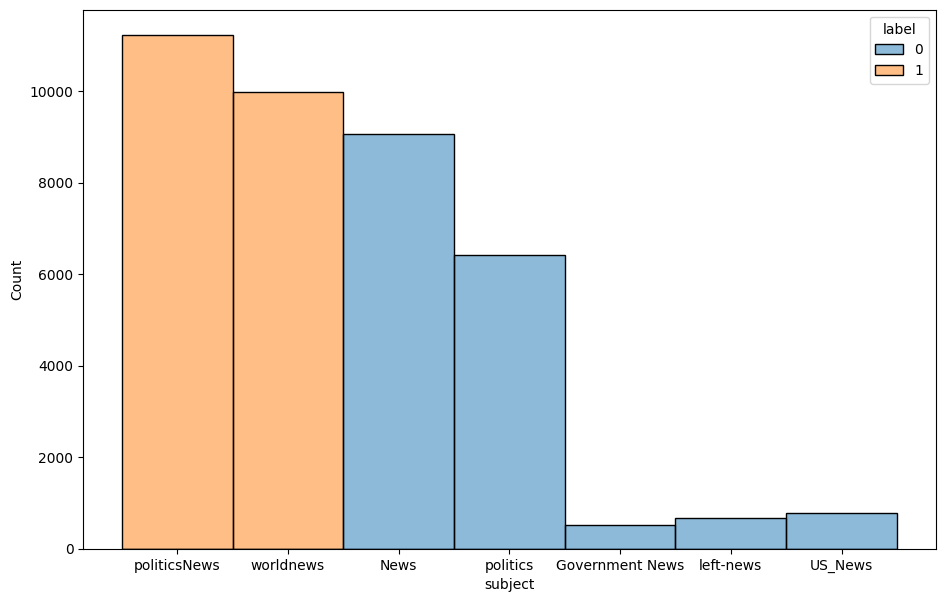

In [55]:
# Plotting histogram of article subjects
fig, hist = plt.subplots(figsize = (11,7))
hist = sns.histplot(data=dataset, x = 'subject', hue="label")

The subjects in fake news are different from the subjects in verified news. Subject will not be taken into account.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


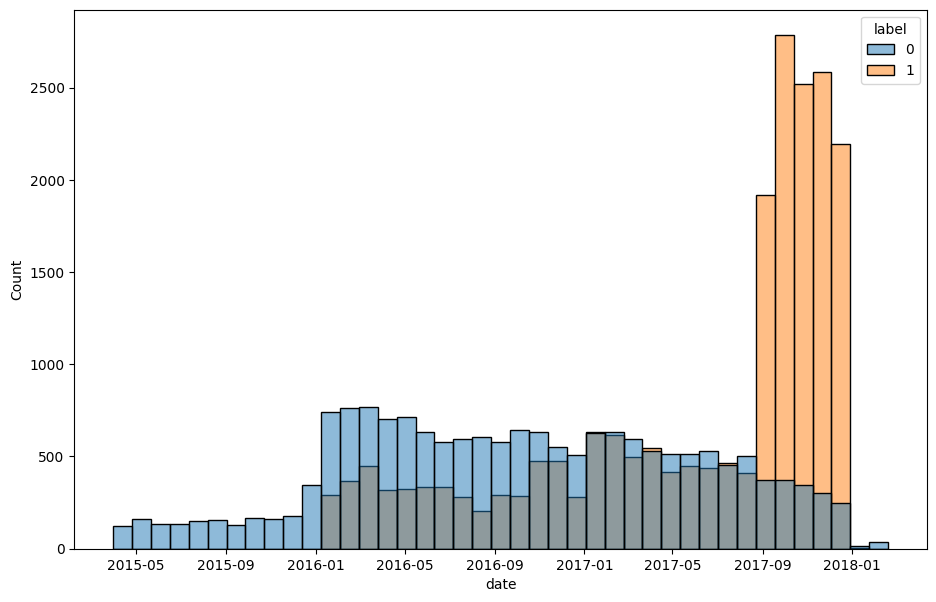

In [56]:
# Plotting histogram of article dates
fig, hist = plt.subplots(figsize = (11,7))
hist = sns.histplot(data=dataset, x = 'date', hue="label")

The date distribution of verified and false articles are varying. Fake articles span from before 2016 and verified articles are recorded from after 2016. Also, most of the verified articles in the dataset seem to be dated between Sep 2017 to Jan 2018.
Date will not be taken into account.

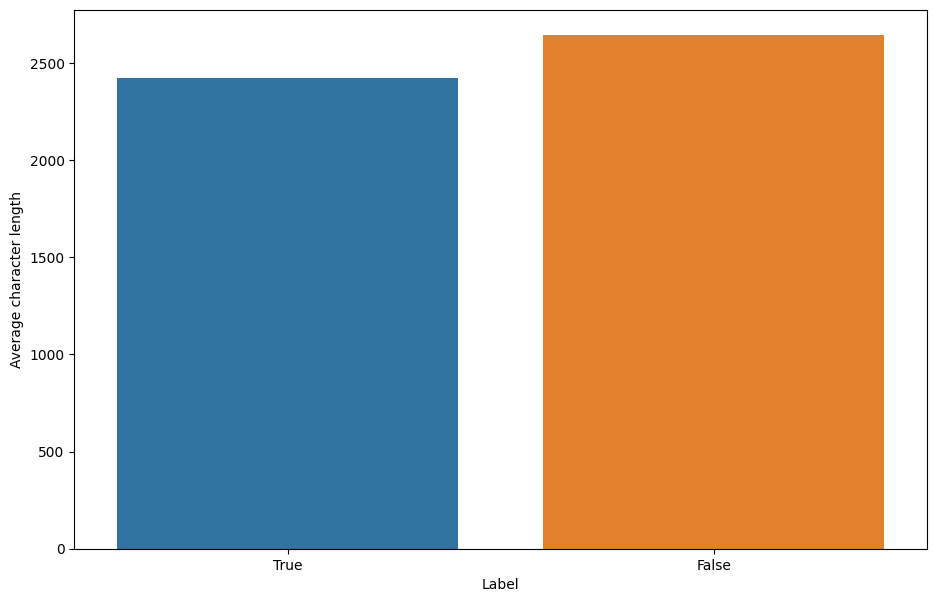

In [57]:
# Text analysis
av_t = dataset[dataset['label'] == 1]['article'].apply(lambda x: len(x)).mean()
av_f = dataset[dataset['label'] == 0]['article'].apply(lambda x: len(x)).mean()
av = pd.DataFrame(data = {'Average character length': [av_t, av_f], 'Label':['True', 'False']})
fig, bar = plt.subplots(figsize = (11,7))
bar = sns.barplot(y='Average character length', x='Label', data=av)

The average between all fake and true news is almost the same.

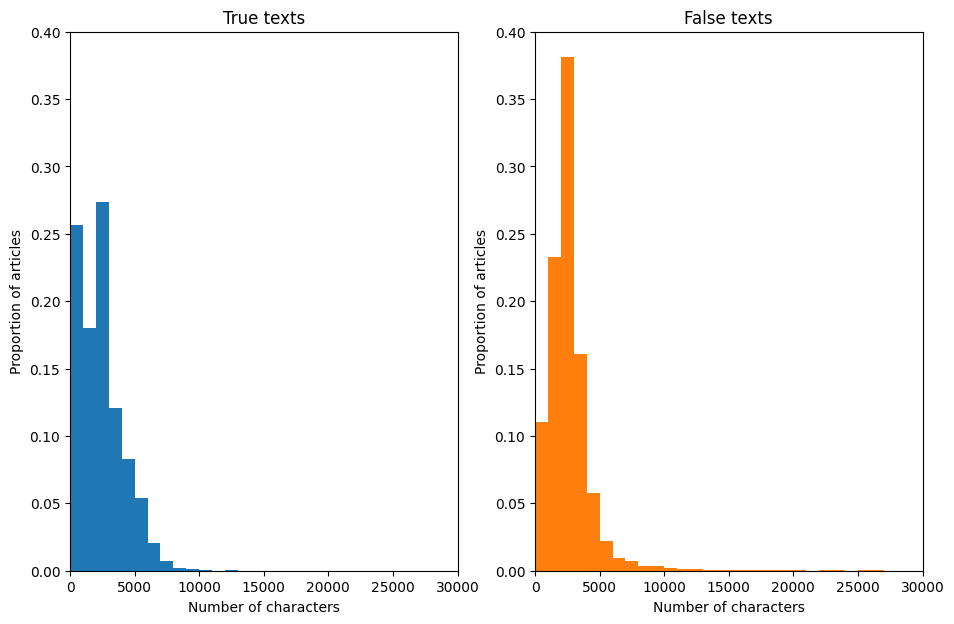

In [58]:
# Characters length of articles
len_cha_true = dataset[dataset['label'] == 1]['article'].apply(lambda x: len(x))
len_cha_fake = dataset[dataset['label'] == 0]['article'].apply(lambda x: len(x))

norm_weights_true = np.ones(len(len_cha_true))/len(len_cha_true)
norm_weights_fake = np.ones(len(len_cha_fake))/len(len_cha_fake)

bins = [i * 1000 for i in range(0,31)]

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_cha_true, bins = bins, weights = norm_weights_true, color = 'C0')
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 30000)
hist1.set_xlabel('Number of characters')
hist1.set_ylabel('Proportion of articles')
hist1.set_title('True texts')

hist2.hist(len_cha_fake, bins = bins, weights = norm_weights_fake, color = 'C1')
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 30000)
hist2.set_xlabel('Number of characters')
hist2.set_ylabel('Proportion of articles')
hist2.set_title('False texts');

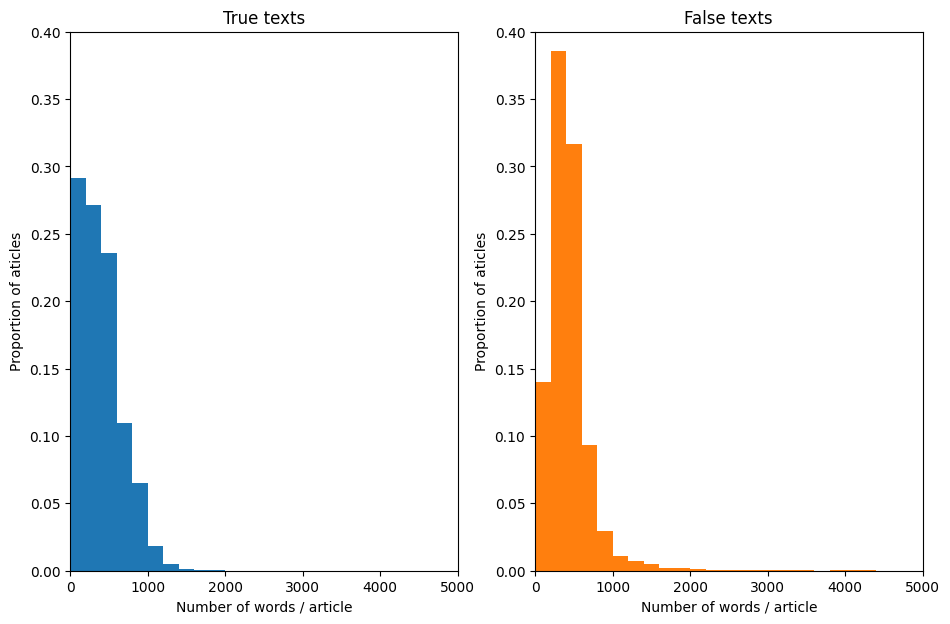

In [59]:
# Number of words per article
len_w_true = dataset[dataset['label'] == 1]['article'].str.split().map(lambda x: len(x))
len_w_fake = dataset[dataset['label'] == 0]['article'].str.split().map(lambda x: len(x))

norm_weights_true = np.ones(len(len_w_true))/len(len_w_true)
norm_weights_fake = np.ones(len(len_w_fake))/len(len_w_fake)

bins_ = [i * 200 for i in range(0,26)]

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_w_true, bins = bins_, weights = norm_weights_true, color = 'C0')
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 5000)
hist1.set_xlabel('Number of words / article')
hist1.set_ylabel('Proportion of aticles')
hist1.set_title('True texts')
hist2.hist(len_w_fake, bins = bins_, weights = norm_weights_fake, color = 'C1')
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 5000)
hist2.set_xlabel('Number of words / article')
hist2.set_ylabel('Proportion of aticles')
hist2.set_title('False texts');

The normalized distribution of both words per article and number of characters between the two labels are somewhat similar.

Defining functions for preprocessing - removal of stopwords, punctuations and sanitization of web elements from the articles. (Useful for LSTM model training)

In [60]:
from string import punctuation
punctuation = list(punctuation)

In [61]:
from tqdm.notebook import tqdm

In [62]:
# https://github.com/remydeshayes/NLP_Pytorch/blob/main/Notebook%20-%20Fake_News%20Detection%20Pytorch%20-%20Billiot_Deshayes.ipynb
stop = stopwords + punctuation + ['“','’', '“', '”', '‘','...']
tqdm.pandas()

def lowerizer(article):
  """
  Lowerize a given text
  ----
  Inputs : 
    article (str) : text to be pre-processed
  Outputs : 
    article.lower() (str) : lowerized text
  """
  return article.lower()

def remove_html(article):
    """
    Remove HTML tags from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text cleaned of HTML tags
    """
    article = re.sub("(<!--.*?-->)", "", article, flags=re.DOTALL)
    return article

def remove_url(article):
    """
    Remove URL tags from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text cleaned of URL tags
    """
    article = re.sub(r'https?:\/\/.\S+', "", article)
    return article

def remove_hashtags(article):
    """
    Remove hashtags from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text cleaned of hashtags
    """
    article = re.sub("#"," ",article)
    return article

def remove_a(article):
    """
    Remove twitter account references @ rom a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text withouttwitter account references 
    """
    article = re.sub("@"," ",article)
    return article

def remove_brackets(article):
    """
    Remove square brackets from a given text 
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text without square brackets
    """
    article = re.sub('\[[^]]*\]', '', article)
    return article

def remove_stop_punct(article):
    """
    Remove punctuation and stopwords from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text without punctuation or stopwords
    """
    final_article = []
    for i in article.split():
        if i not in stop:
            final_article.append(i.strip())
    return " ".join(final_article)

def preprocessing(article, lowerizer_=False, remove_web=True, remove_brackets_=False, remove_stop_punct_=False):
    """
    Computes the above-define steps to clean a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : pre-processed text
    """
    
    if lowerizer_:
        article = lowerizer(article)
    if remove_web:
        article = remove_html(article)
        article = remove_url(article)
        article = remove_hashtags(article)
        article = remove_a(article)
    if remove_brackets_:
        article = remove_brackets(article)
    if remove_stop_punct_:
        article = remove_stop_punct(article)
    return article

In [63]:
dataset['article_lstm'] = dataset['article'].progress_apply(
    lambda x : preprocessing(x, lowerizer_=True, remove_brackets_=True, remove_stop_punct_=True))

  0%|          | 0/38640 [00:00<?, ?it/s]

In [64]:
dataset

,subject,date,article,label,article_lstm
0,politicsNews,2017-12-31,"As U.S. budget fight looms, Republicans flip t...",1,"u.s. budget fight looms, republicans flip fisc..."
1,politicsNews,2017-12-29,U.S. military to accept transgender recruits o...,1,u.s. military accept transgender recruits mond...
2,politicsNews,2017-12-31,Senior U.S. Republican senator: 'Let Mr. Muell...,1,senior u.s. republican senator: 'let mr. muell...
3,politicsNews,2017-12-30,FBI Russia probe helped by Australian diplomat...,1,fbi russia probe helped australian diplomat ti...
4,politicsNews,2017-12-29,Trump wants Postal Service to charge 'much mor...,1,trump wants postal service charge 'much more' ...
...,...,...,...,...,...
38635,US_News,2016-01-07,The White House and The Theatrics of ‘Gun Cont...,0,white house theatrics ‘gun control’.21st centu...
38636,US_News,2016-01-07,Activists or Terrorists? How Media Controls an...,0,activists terrorists? media controls dictates ...
38637,US_News,2016-01-06,"BOILER ROOM – No Surrender, No Retreat, Heads ...",0,"boiler room – surrender, retreat, heads roll –..."
38638,US_News,2016-01-04,Federal Showdown Looms in Oregon After BLM Abu...,0,federal showdown looms oregon blm abuse local ...


# Model prediction

## Data Preparation

In [65]:
# Declaring constants
SEED = 42
MAX_LENGTH = 100

We shuffle the dataset and then split the dataset into training, validation and test datasets.

In [66]:
# Shuffling the dataset
shuffled_data = dataset.sample(frac=1, random_state=SEED).reset_index(drop=True)
shuffled_data

,subject,date,article,label,article_lstm
0,politics,2015-10-14,Democrats Want GOP To Apologize To Hillary For...,0,democrats want gop apologize hillary gut wrenc...
1,News,2016-04-21,Colbert Hilariously Humiliates Ted Cruz For L...,0,colbert hilariously humiliates ted cruz losing...
2,US_News,2016-12-08,Patrick Henningsen LIVE with guest Sean Stone ...,0,patrick henningsen live guest sean stone – ‘pr...
3,worldnews,2017-09-11,Gunmen kill four in sectarian attack in Pakis...,1,gunmen kill four sectarian attack pakistan. gu...
4,politics,2017-03-10,"HILARIOUS MUST WATCH VIDEO: Hollywood Actor, T...",0,"hilarious must watch video: hollywood actor, t..."
...,...,...,...,...,...
38635,politicsNews,2017-01-16,Russia ready to rebuild security ties with U.S...,1,russia ready rebuild security ties u.s. trump:...
38636,worldnews,2017-12-26,Kremlin says ready to mediate North Korea-U.S....,1,kremlin says ready mediate north korea-u.s. ta...
38637,US_News,2017-02-10,FAKE NEWS WEEK: How Mainstream Media ‘Fake New...,0,fake news week: mainstream media ‘fake news’ l...
38638,politicsNews,2017-11-01,"Factbox: Belgian mother of two, young New York...",1,"factbox: belgian mother two, young new yorker ..."


In [67]:
from sklearn.model_selection import train_test_split

In [68]:
X = shuffled_data['article_lstm']
y = shuffled_data['label']

In [69]:
# Train-Validation-Test set split into 80:10:10 ratio
train_X, temp_X, train_y, temp_y = train_test_split(X, y, random_state=SEED, test_size=0.2, stratify=y)
# Validation-Test split
valid_X, test_X, valid_y, test_y = train_test_split(temp_X, temp_y, random_state=SEED, test_size=0.5, stratify=temp_y)

In [70]:
# Return size of the split datasets
(len(train_X), len(train_y)), (len(valid_X), len(valid_y)), (len(test_X), len(test_y))

((30912, 30912), (3864, 3864), (3864, 3864))

In [71]:
# Defining a function to ascertain balance of true and fake news
# https://github.com/remydeshayes/NLP_Pytorch/blob/main/Notebook%20-%20Fake_News%20Detection%20Pytorch%20-%20Billiot_Deshayes.ipynb
def distribution_data(corpus): 
    """
    Returns number of fake and true news in a given dataset
    ----
    Inputs : 
    corpus (array) : labels of our dataset
    Outputs : 
    distrib (pd.DataFrame) : number of true and fake news in the dataset 
    """
    nb_true = corpus.sum()
    nb_false = len(corpus) - nb_true
    distrib = pd.DataFrame(data = {'Number of samples': [nb_true, nb_false], 'Label':['True', 'False']})
    return distrib

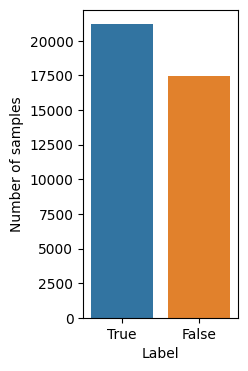

In [72]:
distrib = distribution_data(dataset['label'])
fig, bar = plt.subplots(figsize = (2,4))
bar = sns.barplot(y='Number of samples', x='Label',data=distrib);

There are more Validated news than Falsified news in the dataset, but ideal for the model to be trained.

In [73]:
train_distrib = distribution_data(train_y)
valid_distrib = distribution_data(valid_y)
test_distrib = distribution_data(test_y)

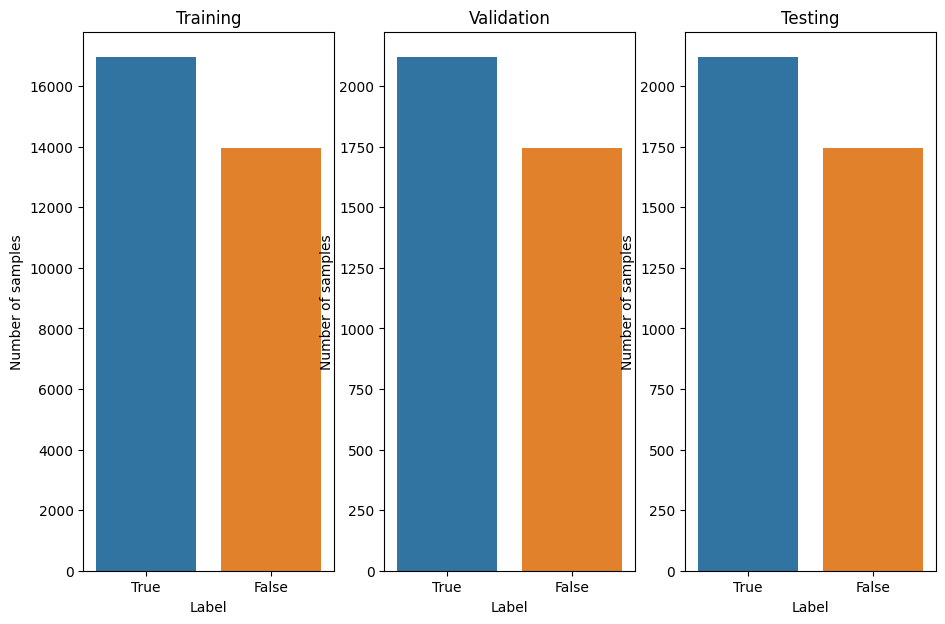

In [74]:
fig, (bar1, bar2, bar3) = plt.subplots(1,3, figsize = (11,7))
sns.barplot(y='Number of samples', x='Label',data=train_distrib, ax = bar1)
sns.barplot(y='Number of samples', x='Label',data=valid_distrib, ax = bar2)
sns.barplot(y='Number of samples', x='Label',data=test_distrib, ax = bar3)
bar1.set_title("Training")
bar2.set_title("Validation")
bar3.set_title("Testing");

The same can be said for the shuffled and split dataset. They share the same ratio of true to fake news.

A class is created that will build vocabulary from the training dataset and create a dictionary - indexes to words and words to indexes.  
The clean article is processed by tokenizing using nltk, transposed to indexes, passed as tensor and padding to a determined length.

In [75]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [76]:
# Importing nltk (yet again)
import nltk
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [77]:
# https://github.com/remydeshayes/NLP_Pytorch/blob/main/Notebook%20-%20Fake_News%20Detection%20Pytorch%20-%20Billiot_Deshayes.ipynb
# Definition of class that will preprocess the words to indexes, tranform to tensor and cut/pad to the desired sequence of length
# These functions are automated when using HuggingFace tokenizers

class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab = None, max_length = 100, min_freq = 5):
        
        self.data = data
        self.max_length = max_length
        
        # Allow to import a vocabulary (validation and testing will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # Build the vocabulary if none is imported
            self.word2idx, self.idx2word = self.build_vocab(self.data, min_freq)
        
        # We tokenize the articles
        tokenized_data = [word_tokenize(file.lower()) for file in self.data]
        # Transform words into lists of indexes
        indexed_data = [[self.word2idx.get(word, self.word2idx['UNK']) for word in file] for file in tokenized_data]
        # Transform into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(file) for file in indexed_data]
        # Lables are passed into a FloatTensor (adding to_numpy() to resolve ValueError)
        # ValueError: could not determine the shape of object type 'Series'
        tensor_y = torch.FloatTensor(categories.to_numpy())
        # Finally we cut too the determined maximum length
        cut_tensor_data = [tensor[:max_length] for tensor in tensor_data]
        # We pad the sequences to have the whole dataset containing sequences of the same length
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value=0)
        self.tensor_y = tensor_y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def build_vocab(self, corpus, count_threshold):
        word_counts = {}
        for sent in tqdm(corpus):
            for word in word_tokenize(sent.lower()):
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1   
        filtered_word_counts = {word: count for word, count in word_counts.items() if count >= count_threshold}        
        words = sorted(filtered_word_counts.keys(), key=word_counts.get, reverse=True) + ['UNK']
        word_index = {words[i] : (i+1) for i in range(len(words))}
        idx_word = {(i+1) : words[i] for i in range(len(words))}
        return word_index, idx_word
    
    def get_vocab(self):
        return self.word2idx, self.idx2word

We start preprocessing the training data, and after building the vocabulary, it is used to prepare the validation and testing dataset.

In [78]:
training_dataset = TextClassificationDataset(train_X, train_y, max_length=MAX_LENGTH)

  0%|          | 0/30912 [00:00<?, ?it/s]

In [80]:
training_word2idx, training_idx2word = training_dataset.get_vocab()
valid_dataset = TextClassificationDataset(valid_X, valid_y, (training_word2idx, training_idx2word), max_length=MAX_LENGTH)
test_dataset = TextClassificationDataset(test_X, test_y, (training_word2idx, training_idx2word), max_length=MAX_LENGTH)

The datasets are then passed into a DataLoader

In [81]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

# Embeddings and Model Definition

A pretrained GloVe embedding with 300 features per word vector is loaded, which had been trained on Wikipedia.  
GloVe leverages global word to word co-occurance counts, in contrast to Word2vec, which leverages co-occurance within neighboring words.

In [ ]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors

[===============================================---] 95.7% 360.1/376.1MB downloaded


After creation of the word to index dictionary, it is passed into the GloVe embedding function. The internal working is commented in the function definition

In [83]:
# https://github.com/remydeshayes/NLP_Pytorch/blob/main/Notebook%20-%20Fake_News%20Detection%20Pytorch%20-%20Billiot_Deshayes.ipynb

def get_glove_adapted_embeddings(glove_model, input_voc):
    """
    Retrieve a vocabulary words'embeddings from GloVe 
    ----
    Inputs : 
    glove_model () : GloVe Embedding model
    input_voc (dict) : dictionnary of our indexed vocabulary 
    Outputs : 
    embeddings (ndarray) : GloVe Embeddings for the given vocabulary with the vocabulary index
    """
    # Create a dict: Get the corresponding GloVe vocabulary from the word index
    keys = {i: glove_model.key_to_index[w] if w in glove_model.key_to_index.keys() else None for w, i in input_voc.items()}
#     print(keys)
    # Create a dict of index corresponding to index of the word in GloVe
    index_dict = {i: key for i, key in keys.items() if key is not None}
    # Create a matrix to retrieve GloVe vectors
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    # Populate the matrix with the vectors and return this matrix
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

In [84]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

The training model is now defined: an embedding layer of dim(vocab_size, 300), two LSTM layers with hidden_size 256, followed by GloVe vectors as embeddings and a fully connected layer.

In [85]:
class LSTMModel(nn.Module):

    def __init__(self, embedding_dim, vocabulary_size, hidden_dim, embeddings=None, fine_tuning=False):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        if embeddings:
            self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(GloveEmbeddings), freeze=not fine_tuning, padding_idx=0)
        else:
            self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1, embedding_dim=embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(in_features=2*hidden_dim, out_features=1)

    def forward(self, inputs):
        emb = self.embeddings(inputs)
        lstm_out, (ht, ct) = self.lstm(emb, None)
        h = torch.cat((ht[-2], ht[-1]), dim=1)
        x = torch.squeeze(self.linear(h))
        return x

# Training

Three functions are defined: `train_epoch` which iterates through the training DataLoader object and computes a complete pass for every batch, `eval_model` which evaluates throught the validation/testing dataset only a forward pass for every batch and `experiment` which iterates through number of epochs for the entire training session.

In [86]:
def train_epoch(model, opt, criterion, dataloader):
    """
    Trains the mode over an epoch 
    ----
    Inputs : 
    model () : defined model to be trained
    opt () : chosen and defined optimizer 
    criterion () : chosen and defined loss
    dataloader() : iterable object with the batches
    Outputs : 
    losses (list) : list of training loss for each batch of the epoch
    accs (list) : list of training accuracy for each batch of the epoch
    """
    model.train()
    losses = []
    accs = []
    for i, (x, y) in enumerate(dataloader):
        opt.zero_grad()
        # Forward pass
        pred = model(x)
        # Loss Computation
        loss = criterion(pred, y)
        # Backward pass
        loss.backward()
        # Weights update
        opt.step()
        losses.append(loss.item())
        # Compute accuracy
        num_corrects = sum((torch.sigmoid(pred)>0.5) == y)
        acc = 100.0 * num_corrects/len(y)
        accs.append(acc.item())
        if (i%20 == 0):
            print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
    return losses, accs

In [87]:
def eval_model(model, criterion, evalloader):
    """
    Evaluate the model  
    ----
    Inputs : 
    model () : defined model to be trained
    criterion () : chosen and defined loss
    evalloader() : iterable object with the batches 
    Outputs : 
    total_epoch_loss/(i+1) (float) : computed loss 
    total_epoch_acc/(i+1) (float) : computed accuracy 
    preds (list) : predictions made by the model
    """
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    preds = []
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            pred = model(x)
            loss = criterion(pred, y)
            num_corrects = sum((torch.sigmoid(pred)>0.5) == y)
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()
            preds.append(pred)

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1), preds

In [88]:
def experiment(model, opt, criterion, num_epochs = 5):
    """
    Trains & Evaluates the model over all epochs 
    ----
    Inputs : 
    model () : defined model to be trained
    opt () : chosen and defined optimizer 
    criterion () : chosen and defined loss
    num_epochs() : chosen number of epochs to go through
    Outputs : 
    train_losses (list): training losses of all batches for each epochs
    valid_losses (list): losses over vaidation data for all epochs
    test_loss (list): loss over test data once the model is trained 
    train_accs (list): training accuracies of all batches for each epochs
    valid_accs (list): accuracies over vaidation data for all epochs
    test_acc (list): accuracy over test data once the model is trained
    test_preds (): predictions on test dataset
    """
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        losses, accs = train_epoch(model, opt, criterion, training_dataloader)
        train_losses.append(losses)
        train_accs.append(accs)
        valid_loss, valid_acc, val_preds = eval_model(model, criterion, valid_dataloader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
    test_loss, test_acc, test_preds = eval_model(model, criterion, test_dataloader)
    print("Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
    return train_losses, valid_losses, test_loss, train_accs, valid_accs, test_acc, test_preds

## Training with LSTM Model

The model is defined, the optimizer used is Adam and the loss function used is binary cross entropy - since the task is binary classification.

In [100]:
# Setting the hyperparameters of the model
EMBEDDING_DIM = 300
VOCAB_SIZE = len(training_word2idx)
HIDDEN_DIM = 256
learning_rate = 0.0025
num_epochs = 10

In [101]:
model_lstm = LSTMModel(EMBEDDING_DIM, VOCAB_SIZE, HIDDEN_DIM,  embeddings=True, fine_tuning=False)
opt = optim.Adam(model_lstm.parameters(), lr=learning_rate, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

In [102]:
train_losses_lstm, valid_losses_lstm, test_loss_lstm, train_accs_lstm, valid_accs_lstm, test_acc_lstm, test_preds_lstm = experiment(model_lstm, opt, criterion, num_epochs)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6929022073745728; training acc = 54.0
Batch 20 : training loss = 0.5167807936668396; training acc = 81.5
Batch 40 : training loss = 0.4454807937145233; training acc = 83.0
Batch 80 : training loss = 0.5823344588279724; training acc = 77.5
Batch 100 : training loss = 0.35259905457496643; training acc = 87.0
Batch 120 : training loss = 0.3883746266365051; training acc = 84.0
Batch 140 : training loss = 0.46906569600105286; training acc = 84.5
Epoch 1 : Validation loss = 0.4666687974045354; Validation acc = 78.86082950715095
Epoch 2:
Batch 0 : training loss = 0.4651698172092438; training acc = 79.5
Batch 20 : training loss = 0.3048153221607208; training acc = 89.5
Batch 40 : training loss = 0.22694163024425507; training acc = 91.0
Batch 60 : training loss = 0.21713079512119293; training acc = 91.5
Batch 80 : training loss = 0.17233604192733765; training acc = 93.0
Batch 120 : training loss = 0.1430796980857849; training acc = 93.5

Test accuracy of 99.63% is quite a high metric so the model weights are saved.

In [128]:
torch.save(model_lstm, '/kaggle/working/lstm_saved_weights.pt')
torch.save(model_lstm.state_dict(), '/kaggle/working/lstm_state_dict.pt')

The training and validation accuracy is plotted against the number of epochs

In [103]:
import statistics
from statistics import mean

In [104]:
train_losses = [mean(train_loss) for train_loss in train_losses_lstm]
train_accs = [mean(train_acc) for train_acc in train_accs_lstm]

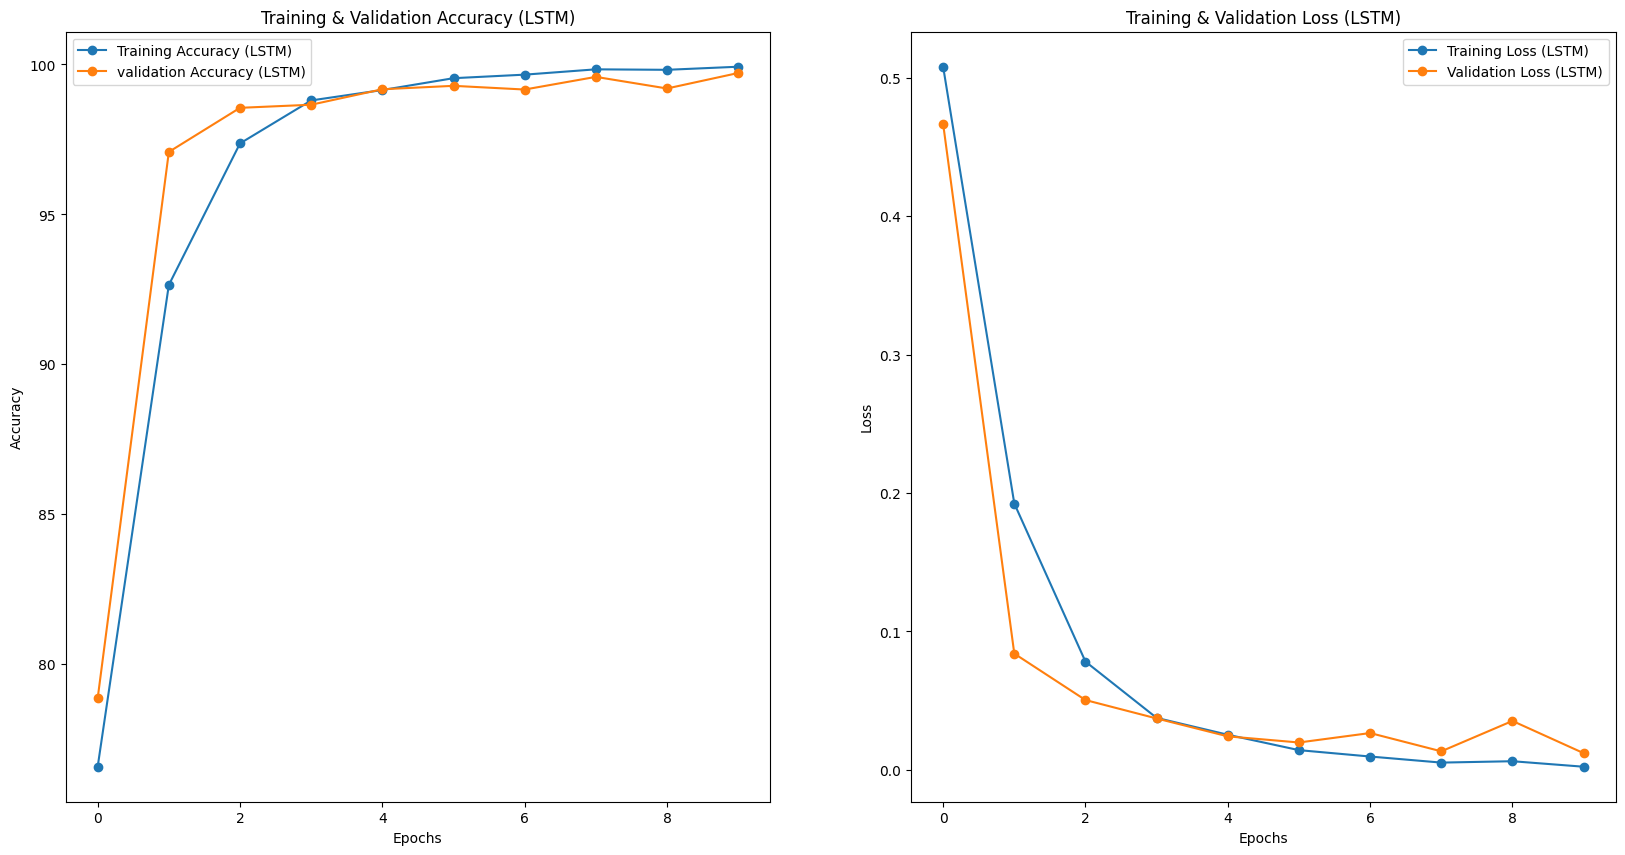

In [105]:
epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs , 'C0o-' , label = 'Training Accuracy (LSTM)')
ax[0].plot(epochs , valid_accs_lstm , 'C1o-' , label = 'validation Accuracy (LSTM)')
ax[0].set_title('Training & Validation Accuracy (LSTM)')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses , 'C0o-' , label = 'Training Loss (LSTM)')
ax[1].plot(epochs , valid_losses_lstm , 'C1o-' , label = 'Validation Loss (LSTM)')
ax[1].set_title('Training & Validation Loss (LSTM)')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

## Training with CNN

Definition of a CNN model to establish performance comparison versus LSTM. The CNN model has a similar embedding layer with size (vocab_size, embedding_dim=300), a CNN layer with size (embedding_size = 300, 64, 16) with ReLU activation function, max-pooling layer, dropout layer set to 0.5 and a fully connected layer (64, 1)

In [106]:
from torch.nn import functional as F

class CNNModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, window_size: int = 16, filter_multiplier = 64, embeddings = None, fine_tuning = False):
        super().__init__()
        self.embedding_dim = embedding_dim 
        if embeddings:
            self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(GloveEmbeddings), freeze=not fine_tuning, padding_idx=0)
        else:
            self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1, embedding_dim=embedding_dim, padding_idx=0)

        self.conv1d = nn.Conv1d(embedding_dim, filter_multiplier, window_size)
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(filter_multiplier, 1)

    def forward(self, inputs):
        x = self.embeddings(inputs)
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = F.relu(x)
        x = F.max_pool1d(x, x.shape[2]).squeeze(2)
        x = self.dropout(x)
        output = torch.squeeze(self.linear(x))

        return output

The Adam optimizer and Binary Cross Entropy Loss criterion is kept the same as before.

In [107]:
model_cnn = CNNModel(300, len(training_word2idx), 16, 64, embeddings = True, fine_tuning=True)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

In [108]:
train_losses_cnn, valid_losses_cnn, test_loss_cnn, train_accs_cnn, valid_accs_cnn, test_acc_cnn, test_preds_cnn = experiment(model_cnn, optimizer, criterion, num_epochs=7)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.7344611287117004; training acc = 42.5
Batch 20 : training loss = 0.14379528164863586; training acc = 95.0
Batch 60 : training loss = 0.03259853273630142; training acc = 99.5
Batch 80 : training loss = 0.020803185179829597; training acc = 99.5
Batch 100 : training loss = 0.03837227448821068; training acc = 98.5
Batch 120 : training loss = 0.016116825863718987; training acc = 99.5
Batch 140 : training loss = 0.01958792470395565; training acc = 99.5
Epoch 1 : Validation loss = 0.026355051347279862; Validation acc = 99.01935483870967
Epoch 2:
Batch 0 : training loss = 0.0042536938562989235; training acc = 100.0
Batch 20 : training loss = 0.004966428503394127; training acc = 100.0
Batch 40 : training loss = 0.003289171727374196; training acc = 100.0
Batch 60 : training loss = 0.009685416705906391; training acc = 99.5
Batch 80 : training loss = 0.004056186880916357; training acc = 100.0
Batch 100 : training loss = 0.00876322668045759

In [115]:
train_losses_cnn = [mean(train_loss) for train_loss in train_losses_cnn]
train_accs_cnn = [mean(train_acc) for train_acc in train_accs_cnn]

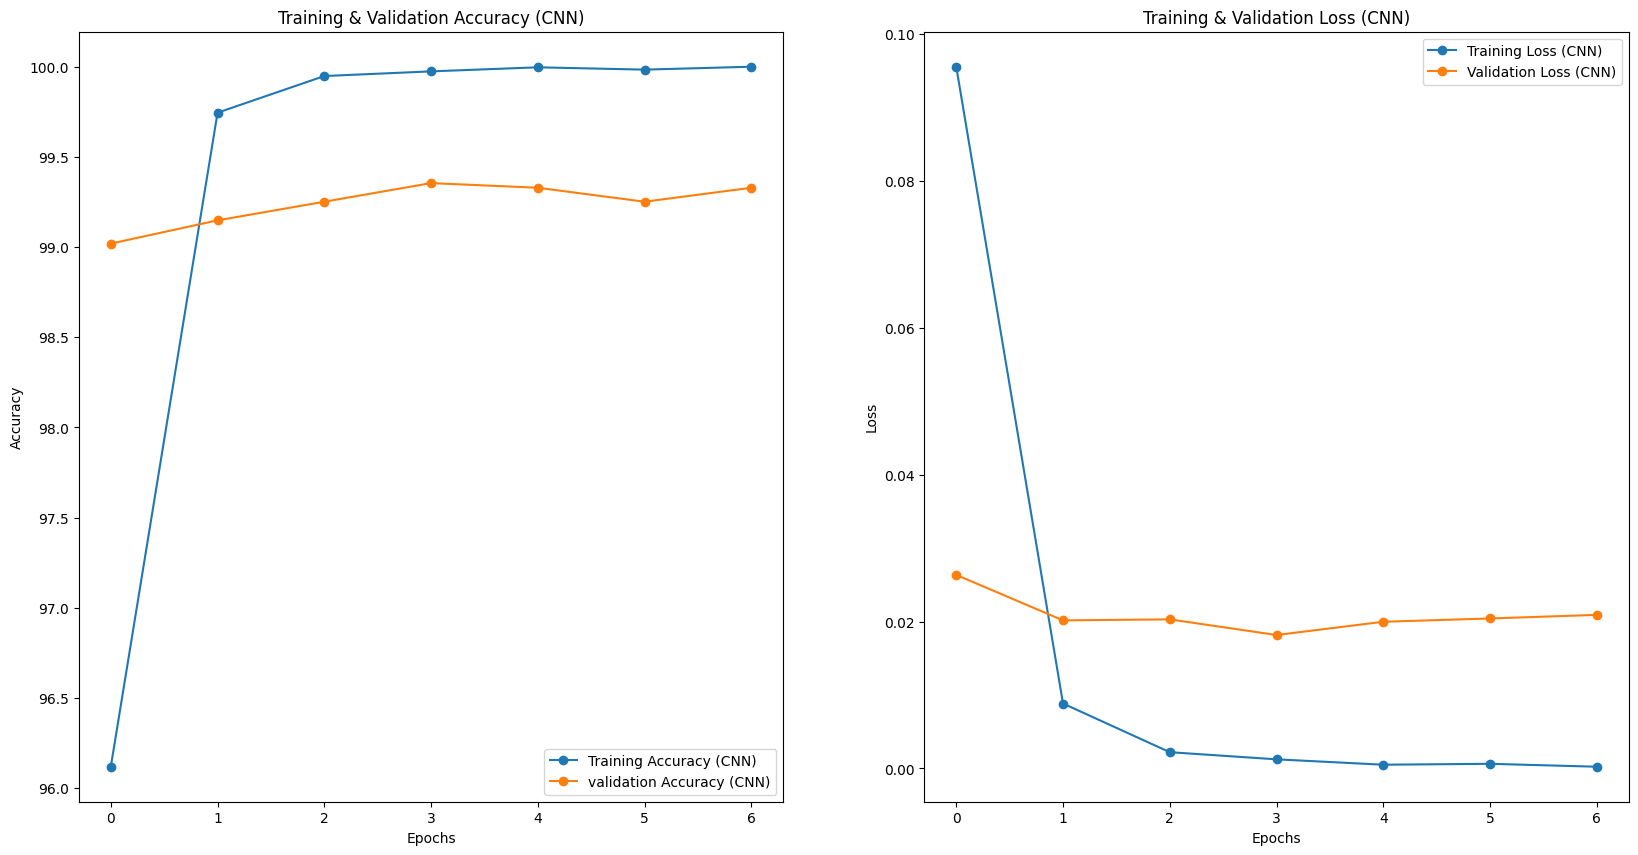

In [116]:
epochs = [i for i in range(7)] # epochs is 7
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs_cnn , 'C0o-' , label = 'Training Accuracy (CNN)')
ax[0].plot(epochs , valid_accs_cnn , 'C1o-' , label = 'validation Accuracy (CNN)')
ax[0].set_title('Training & Validation Accuracy (CNN)')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses_cnn , 'C0o-' , label = 'Training Loss (CNN)')
ax[1].plot(epochs , valid_losses_cnn , 'C1o-' , label = 'Validation Loss (CNN)')
ax[1].set_title('Training & Validation Loss (CNN)')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

The model has overfitted to the training data, but the CNN model is unable to converge closer to the training accuracy metric, compared to the LSTM model.

# Evaluation of LSTM Model

The LSTM model is evaluated using confusion matrix and classification report metrics.

In [117]:
preds = [(torch.sigmoid(t)>0.5).tolist() for t in test_preds_lstm]
preds = [int(t) for el in preds for t in el]

In [118]:
# Predictions
preds[:20]

[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1]

In [119]:
# Ground Truth
test_y[:20]

21832    1
36890    1
7411     1
36653    1
2369     0
29967    1
4135     1
19038    1
27786    0
17479    1
36772    1
24103    0
2245     1
846      1
38278    1
26801    0
31166    0
19382    1
19403    0
36068    1
Name: label, dtype: int64

In [120]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, preds)
cm_ = pd.DataFrame(cm , index = ['True','Fake'] , columns = ['True','Fake'])

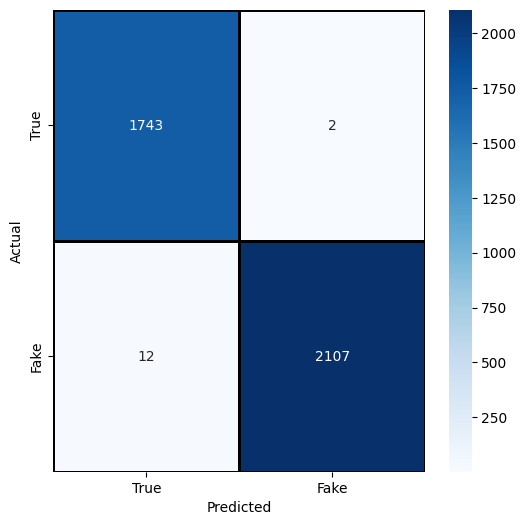

In [125]:
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['True','Fake'] , yticklabels = ['True','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual");

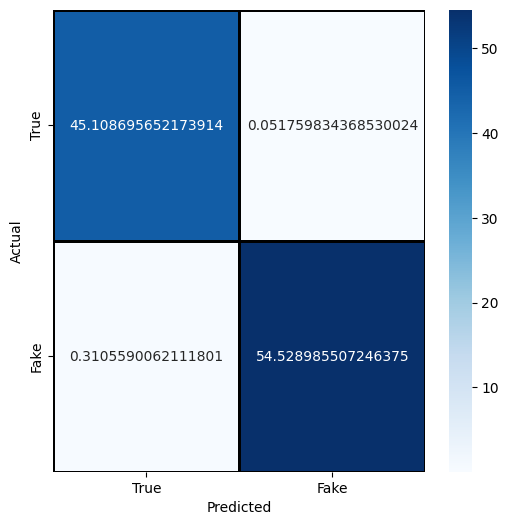

In [139]:
plt.figure(figsize = (6,6))
sns.heatmap(cm/3864*100,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['True','Fake'] , yticklabels = ['True','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual");

In [126]:
from sklearn.metrics import classification_report
print(classification_report(test_y, preds, target_names = ['Predicted Fake','Predicted True']))

                precision    recall  f1-score   support

Predicted Fake       0.99      1.00      1.00      1745
Predicted True       1.00      0.99      1.00      2119

      accuracy                           1.00      3864
     macro avg       1.00      1.00      1.00      3864
  weighted avg       1.00      1.00      1.00      3864



# Thoughts

The binary classification of detecting fake news can be solved nowadays using Transformers. While using the LSTM and the CNN models to train, GloVe embeddings were utilized to convert words into their corresponding vectors. GloVe leverages global word-to-word co-occurences which effect the final word vector. This is comparable to the how the attention layers of the Transformer models are able to understand word context in a given passage of text.  
It could be said that while the CNN model came close to the verification accuracy, the consequences of overfitting made it a poor architecture when compared to the LSTM model. An RNN would therefore have a better performance index than the CNN model. It would however run into the problem of vanishing or exploding gradients. Since LSTM solves this problem, it would be unwise to reinvent the wheel.

# Training on BERT

Preprocessing the data suitable for BERT tokenizer and BERT Transformer model. As most of the preprocessing has already been done, some of the steps would be straightforward.

In [71]:
shuffled_data['article_bert'] = shuffled_data['article'].progress_apply(
    lambda x : preprocessing(x, lowerizer_=False, remove_web=True, remove_brackets_=False, remove_stop_punct_=False))

  0%|          | 0/38640 [00:00<?, ?it/s]

In [72]:
shuffled_data

,subject,date,article,label,article_lstm,article_bert
0,politics,2015-10-14,Democrats Want GOP To Apologize To Hillary For...,0,democrats want gop apologize hillary gut wrenc...,Democrats Want GOP To Apologize To Hillary For...
1,News,2016-04-21,Colbert Hilariously Humiliates Ted Cruz For L...,0,colbert hilariously humiliates ted cruz losing...,Colbert Hilariously Humiliates Ted Cruz For L...
2,US_News,2016-12-08,Patrick Henningsen LIVE with guest Sean Stone ...,0,patrick henningsen live guest sean stone – ‘pr...,Patrick Henningsen LIVE with guest Sean Stone ...
3,worldnews,2017-09-11,Gunmen kill four in sectarian attack in Pakis...,1,gunmen kill four sectarian attack pakistan. gu...,Gunmen kill four in sectarian attack in Pakis...
4,politics,2017-03-10,"HILARIOUS MUST WATCH VIDEO: Hollywood Actor, T...",0,"hilarious must watch video: hollywood actor, t...","HILARIOUS MUST WATCH VIDEO: Hollywood Actor, T..."
...,...,...,...,...,...,...
38635,politicsNews,2017-01-16,Russia ready to rebuild security ties with U.S...,1,russia ready rebuild security ties u.s. trump:...,Russia ready to rebuild security ties with U.S...
38636,worldnews,2017-12-26,Kremlin says ready to mediate North Korea-U.S....,1,kremlin says ready mediate north korea-u.s. ta...,Kremlin says ready to mediate North Korea-U.S....
38637,US_News,2017-02-10,FAKE NEWS WEEK: How Mainstream Media ‘Fake New...,0,fake news week: mainstream media ‘fake news’ l...,FAKE NEWS WEEK: How Mainstream Media ‘Fake New...
38638,politicsNews,2017-11-01,"Factbox: Belgian mother of two, young New York...",1,"factbox: belgian mother two, young new yorker ...","Factbox: Belgian mother of two, young New York..."


## Split the training dataset

In [73]:
bert_X = shuffled_data['article_bert']
bert_y = shuffled_data['label']

In [74]:
# Train-Validation-Test set split into 80:10:10 ratio
b_train_X, b_temp_X, b_train_y, b_temp_y = train_test_split(bert_X, bert_y, random_state=SEED, test_size=0.2, stratify=y)
# Validation-Test split
b_valid_X, b_test_X, b_valid_y, b_test_y = train_test_split(b_temp_X, b_temp_y, random_state=SEED, test_size=0.5, stratify=temp_y)

In [75]:
# Return size of the split datasets
(len(b_train_X), len(b_train_y)), (len(b_valid_X), len(b_valid_y)), (len(b_test_X), len(b_test_y))

((30912, 30912), (3864, 3864), (3864, 3864))

## Import BERT Model and Tokenizer

In [76]:
import transformers
from transformers import AutoModel, BertTokenizerFast

In [78]:
import torch

In [79]:
# specify GPU
device = torch.device("cuda")

In [80]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## BERT Tokenization of the split datasets

In [81]:
# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    b_train_X.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    b_valid_X.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    b_test_X.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Convert Integer Sequences to Tensors

In [82]:
# For train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
b_train_y_ = torch.tensor(b_train_y.tolist())

# For validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
b_val_y_ = torch.tensor(b_valid_y.tolist())

# For test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
b_test_y_ = torch.tensor(b_test_y.tolist())

## Create DataLoaders

In [83]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [84]:
# Define a batch size
batch_size = 32
torch.manual_seed(SEED)

# train_data
train_data = TensorDataset(train_seq, train_mask, b_train_y_)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# val_data
val_data = TensorDataset(val_seq, val_mask, b_val_y_)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# test_data
test_data = TensorDataset(test_seq, test_mask, b_test_y_)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

## Freeze BERT Parameters

In [85]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define BERT Architecture

In [87]:
from torch import nn

In [88]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        self.dropout = nn.Dropout(0.1)
        self.relu =  nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)

        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        x = self.softmax(x)

        return x

In [89]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [90]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Get Class Weights

In [91]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_y), y=train_y)

print(class_wts)

[1.10732197 0.91164327]


In [92]:
# convert class weights to tensor
weights = torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

In [96]:
# number of training epochs
BERT_EPOCHS = 40

## Fine tuning BERT

In [94]:
# function to train the model
def train():

    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print("  Batch {:>5,}  of  {:>5,}.".format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds

In [95]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Report progress.
            print("  Batch {:>5,}  of  {:>5,}.".format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# BERT Model Training

In [97]:
# set initial loss to infinite
best_valid_loss = float("inf")

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# early stop
EARLY_STOP = 5

es_counter = 0

# for each epoch
for epoch in tqdm(range(BERT_EPOCHS)):

    print("\n Epoch {:} / {:}".format(epoch + 1, BERT_EPOCHS))

    # train model
    train_loss, _ = train()

    # evaluate model
    valid_loss, _ = evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        # Reset early stop
        es_counter = 0
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "saved_weights.pt")

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"\nTraining Loss: {train_loss:.3f}")
    print(f"Validation Loss: {valid_loss:.3f}")
    
    es_counter += 1
    if es_counter == EARLY_STOP:
        print(f"Training stopped early at epoch {epoch + 1}")
        break

  0%|          | 0/40 [00:00<?, ?it/s]


 Epoch 1 / 40
  Batch    50  of    966.
  Batch   100  of    966.
  Batch   150  of    966.
  Batch   200  of    966.
  Batch   250  of    966.
  Batch   300  of    966.
  Batch   350  of    966.
  Batch   400  of    966.
  Batch   450  of    966.
  Batch   500  of    966.
  Batch   550  of    966.
  Batch   600  of    966.
  Batch   650  of    966.
  Batch   700  of    966.
  Batch   750  of    966.
  Batch   800  of    966.
  Batch   850  of    966.
  Batch   900  of    966.
  Batch   950  of    966.

Evaluating...
  Batch    50  of    121.
  Batch   100  of    121.

Training Loss: 0.256
Validation Loss: 0.190

 Epoch 2 / 40
  Batch    50  of    966.
  Batch   100  of    966.
  Batch   150  of    966.
  Batch   200  of    966.
  Batch   250  of    966.
  Batch   300  of    966.
  Batch   350  of    966.
  Batch   400  of    966.
  Batch   450  of    966.
  Batch   500  of    966.
  Batch   550  of    966.
  Batch   600  of    966.
  Batch   650  of    966.
  Batch   700  of    966.


## Model Performance

In [98]:
# Visualise the train_loss vs valid_loss
data_preproc = pd.DataFrame({
    'train_loss': train_losses,
    'valid_loss': valid_losses})

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


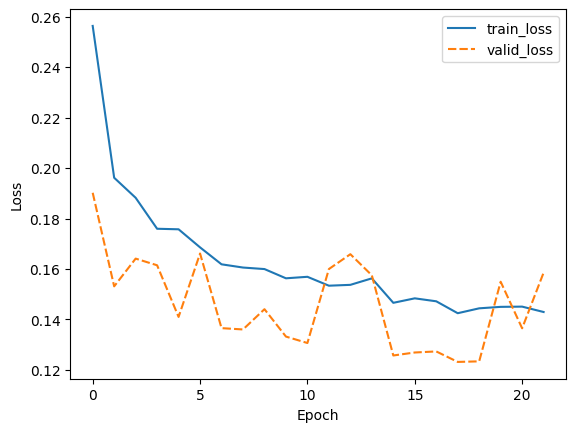

In [100]:
loss_plot = sns.lineplot(data_preproc)
loss_plot.set(xlabel='Epoch', ylabel='Loss');

## Model Evaluation

In [107]:
# load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [102]:
from sklearn.metrics import classification_report

In [108]:
# get predictions for test data
with torch.no_grad():
#     preds = model(test_seq.to(device), test_mask.to(device))
#     preds = preds.detach().cpu().numpy()    

    cross_matrix = []
    
    for step, batch in tqdm(enumerate(test_dataloader)):

#         if step > 0:
#             break

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # get model predictions for the current batch
        preds = model(sent_id, mask)
        preds = preds.detach().cpu().numpy()
        
        # model's performance
        preds = np.argmax(preds, axis = 1)
        print(classification_report(labels.cpu(), preds))
        
        # confusion matrix
        cross_matrix.append(pd.crosstab(labels.cpu(), preds))

0it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        22

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        18

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.95      0.91      0.93        22

    accuracy                           0.91        32
   macro avg       0.89      0.90      0.89        32
weighted avg       0.91      0.91      0.91        32

              preci

In [109]:
final_cm = sum(cross_matrix)
final_cm

col_0,0,1
row_0,,
0,1644,101
1,73,2046


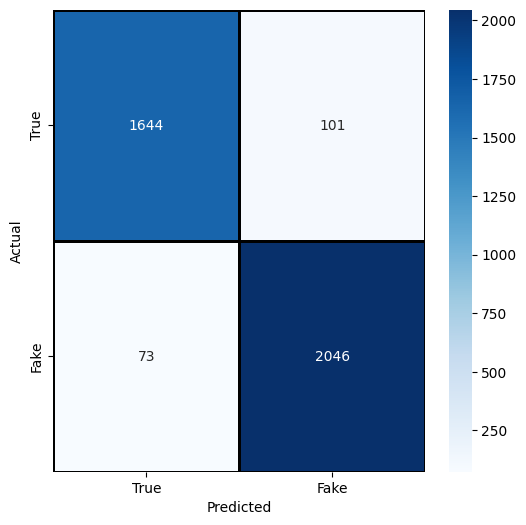

In [110]:
plt.figure(figsize = (6,6))
sns.heatmap(final_cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['True','Fake'] , yticklabels = ['True','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual");

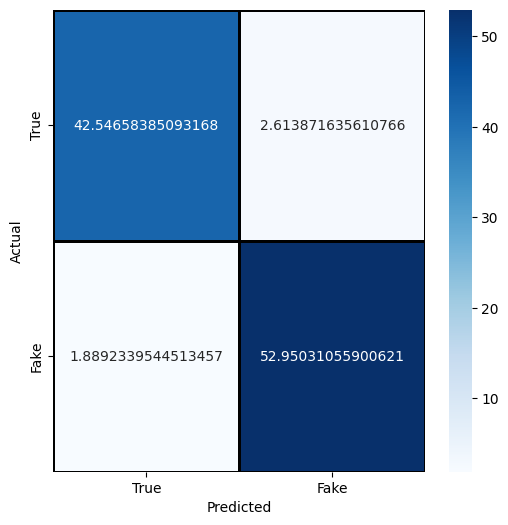

In [111]:
plt.figure(figsize = (6,6))
sns.heatmap(final_cm/3864*100,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['True','Fake'] , yticklabels = ['True','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual");

# Final Thoughts

The BERT model performs slightly worse than the LSTM model. The complexity of the model might be the reason for not being able to converge to the optimum results. Additionally, tuning the learning rate and other hyperparameters could further improve the performance of the model. The LSTM model also benefitted from learning on pre-trained embeddings while removing stopwords and unintelligible words.